<a href="https://colab.research.google.com/github/qazalmehrban/Medical-Segmentation/blob/ghazal/Unet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import nibabel as nib
import os 
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import resize

import torch
import torch.nn as nn

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
samples = '/content/drive/MyDrive/samples/'
labels = '/content/drive/MyDrive/segmentation/'
mix = '/content/drive/MyDrive/New folder/'
#patients = next(os.walk(samples))[2]

#segmentations =next(os.walk(labels))[2]


In [7]:
#patients_object = os.scandir(samples)
#patients_list = [i.path for i in patients_object]
patients_list = glob.glob(mix + '*[0-9].*')
patients_list.sort()

#segment_object = os.scandir(labels)
#segment_list = [i.path for i in segment_object]
segment_list = glob.glob(mix + '*n.*')
segment_list.sort()










In [12]:
def make_box(mask):
    box = []
    box_bool=[]
    obj_ids = np.unique(mask)
    if mask.dtype == bool:
        if len(np.unique(mask))==2:
            
            y_min = np.nonzero(mask)[0].min()
            y_max = np.nonzero(mask)[0].max()
            x_min = np.nonzero(mask)[1].min()
            x_max = np.nonzero(mask)[1].max()
            box=[x_min, y_min, x_max, y_max]
    else :
        mask_bool = mask.astype(np.bool)
        if len(np.unique(mask_bool))==2:
            
            y_min = np.nonzero(mask_bool)[0].min()
            y_max = np.nonzero(mask_bool)[0].max()
            x_min = np.nonzero(mask_bool)[1].min()
            x_max = np.nonzero(mask_bool)[1].max()
            box_bool=[x_min, y_min, x_max, y_max]
        
        for i in  obj_ids[1:]:
            y_min = np.nonzero(mask==i)[0].min()
            y_max = np.nonzero(mask==i)[0].max()
            x_min = np.nonzero(mask==i)[1].min()
            x_max = np.nonzero(mask==i)[1].max()
            box.append([x_min, y_min, x_max, y_max])
    return_object = {'bbox_bool': box} if mask.dtype ==bool else {'bbox_label': dict(zip([f"label{int(i)}" for i in obj_ids[1:]],box)), 'bbox_bool' : box_bool}
    return return_object

In [13]:
masks = nib.load(segment_list[67])
masks = np.array(masks.dataobj)
slice_label(masks)

{'label_0': [0, 1, 18, 19],
 'label_1': [2, 11, 12, 13, 14, 15, 16, 17],
 'label_2': [3, 4, 5, 6, 7, 8, 9, 10]}

In [15]:
make_box(masks[:,:,3])

{'bbox_bool': [174, 155, 229, 232],
 'bbox_label': {'label1': [175, 155, 229, 232],
  'label2': [174, 184, 212, 231]}}

In [57]:
masks.shape, np.unique(masks)

((320, 320, 28), array([0, 1], dtype=int16))

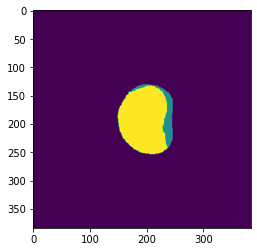

In [79]:
plt.imshow(masks[:,:,10])

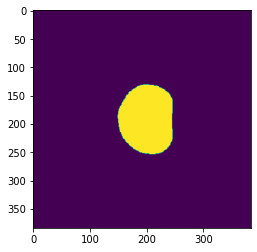

In [80]:
plt.imshow(masks[:,:,10].astype(np.bool))

In [1]:
def slice_label(masks):

  l0 = []
  l1 =[]
  l2 = []
  for i in range(masks.shape[-1]):
    if len(np.unique(masks[:,:,i])) ==1:
      l0.append(i)
    elif len(np.unique(masks[:,:,i])) ==2:
      l1.append(i)
    elif len(np.unique(masks[:,:,i])) ==3:
      l2.append(i)
  return {'label_0':l0, 'label_1':l1,'label_2': l2}

In [2]:
slice_label(masks)

NameError: ignored

In [ ]:
def bounding_box_plot(Masks_2d):
  
  print(f'labels_slice_{slices}', np.unique(Masks_2d))
  print('bounding_box', make_box(Masks_2d.astype(bool)))

  fig=px.imshow(Masks_2d)

  li = make_box(Masks_2d.astype(bool))

  k = dict(x0= li[0], x1= li[2], y0= li[1], y1= li[3])
  fig.add_shape(
    type='rect',
    **k,
    xref='x', yref='y',
    line_color='cyan'
  )
  fig.show()

In [ ]:
def crop_specific(im, mask, crop_size):
        
        k=make_box(mask.astype(np.bool))
        if len(k)!=0:
            b_list = k
            x_min, y_min, x_max, y_max = b_list
            
            length_x = x_max -x_min + 1
            length_y = y_max - y_min + 1
            del_x = crop_size - length_x 
            del_y = crop_size - length_y 

            if del_x%2==0:
                kx = del_x//2
                sx=0
            else:
                kx = del_x//2

                sx = 1
            if del_y%2==0:
                ky = del_y//2
                sy=0
            else:
                ky = del_y//2
                sy = 1
            
            crop = mask[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            crop_im = im[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            return crop_im, crop, 


In [ ]:
crop_size = 192
p_seg = []
p_im = []
for patient_file, segment_file in zip( patients_list[:60], segment_list[:60]):
    im = nib.load(patient_file)    
    im = np.array(im.dataobj)

    Masks = nib.load(segment_file)    
    Masks = np.array(Masks.dataobj)
    Masks.shape
    for  j in range(Masks.shape[2]):
      k=make_box(Masks[:,:,j].astype(np.bool))
      if len(k)!=0:
        crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
        p_seg.append(crop)
        p_im.append(crop_im)


    
   

In [ ]:
crop_size = 192
p_seg_t = []
p_im_t = []
for patient_file, segment_file in zip( patients_list[60:], segment_list[60:]):
    im = nib.load(patient_file)    
    im = np.array(im.dataobj)

    Masks = nib.load(segment_file)    
    Masks = np.array(Masks.dataobj)
    Masks.shape
    for  j in range(Masks.shape[2]):
      k=make_box(Masks[:,:,j].astype(np.bool))
      if len(k)!=0:
        crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
        p_seg_t.append(crop)
        p_im_t.append(crop_im)



In [ ]:
segment_numpy = np.stack(p_seg,0)
image_numpy = np.stack(p_im, 0)

segment_numpy_t = np.stack(p_seg_t,0)
image_numpy_t = np.stack(p_im_t, 0)

In [ ]:
train = image_numpy/image_numpy.max()
test = image_numpy_t/image_numpy.max()

In [ ]:
train_seg_bolean = segment_numpy.astype(bool)
test_seg_bolean = segment_numpy_t.astype(bool)

In [ ]:
test_seg_f = np.float32(test_seg_bolean)
train_seg_f = np.float32(train_seg_bolean)

# Pytorch

In [ ]:
train_image_torch = np.expand_dims(train_image,1)
train_seg_torch  = np.expand_dims(train_seg_f,1)

In [ ]:
train_image_torch.shape

In [ ]:
def conv1x1_bn_relu(inp_activation, output_activation, BN=True, activation = True):
    "con 1x1 + Batchnormalization + relu"
    layer = [nn.Conv2d(inp_activation, output_activation, 1)]
    for i, j in zip([nn.BatchNorm2d(output_activation), nn.ReLU(inplace=True)],[BN, activation]):
        if j==True:
            layer.append(i)
    return nn.Sequential(*layer)

In [ ]:
def conv3x3_bn_relu(inp_activation, output_activation, BN=True, activation = True):
    "con 3x3 + Batchnormalization + relu"
    layer = [nn.Conv2d(inp_activation, output_activation, 3, padding = 1)]
    for i, j in zip([nn.BatchNorm2d(output_activation), nn.ReLU(inplace=True)],[BN, activation]):
        if j==True:
            layer.append(i)
    return nn.Sequential(*layer)

In [ ]:
class bottleneck_block(nn.Module):
    
    def __init__(self, input_activation, list_filter=[256, 64, 256], down = None):
        super().__init__()
        self.conv1x1_1 = conv1x1_bn_relu(input_activation, list_filter[0])
        self.conv3x3 = conv3x3_bn_relu(list_filter[0], list_filter[1])
        self.conv1x1_2 = conv1x1_bn_relu(list_filter[1], list_filter[2])
        self.down = down
        if down!=None:
            self.contract_conv = down
    def forward(self , inp):
        x = inp
        c = self.conv1x1_1(inp)
        c = self.conv3x3(c)
        result = self.conv1x1_2(c)
        if self.down!=None:
            x = self.contract_conv(inp)
        
        out = result + x
        
        return out
            


In [ ]:
class conv_block(nn.Module):
    
    def __init__(self, inp_activation, list_filter ,resnet_block = False, downsample= None ):
        super().__init__()
        self.conv3x3_1 = conv3x3_bn_relu(inp_activation, list_filter)
        self.conv3x3_2 = conv3x3_bn_relu(list_filter, list_filter)
        self.down = downsample
    def forward(self , inp):
        c = self.conv3x3_1(inp)
        c = self.conv3x3_2(c)
        return c

In [ ]:
class Unet_res_b(nn.Module):
    def __init__(self, n_class):
        
        super().__init__()
        self.en_block1 = conv_block(1,32)
        self.en_block2 = conv_block(32,64)
        self.en_block3 = conv_block(64,128)
        self.en_block4 = conv_block(128,256)
        self.en_block5 = conv_block(256,512)
        self.en_block6 = conv_block(512, 1024)

        
        self.transpose5 = nn.ConvTranspose2d(1024,512,2,2)
        self.transpose4 = nn.ConvTranspose2d(512,256,2,2)

        self.transpose3 = nn.ConvTranspose2d(256,128,2,2)
        self.transpose2 = nn.ConvTranspose2d(128,64,2,2)
        self.transpose1 = nn.ConvTranspose2d(64,32,2,2)
        
        self.de_block1 = conv_block(64,32)
        self.de_block2 = conv_block(128,64)
        self.de_block3 = conv_block(256,128)

        self.de_block4 = conv_block(512, 256)
        self.de_block5 = conv_block(1024, 512)
        self.out_conv = nn.Conv2d(32, 1, 1)

        
    

    def forward(self, inp):
        el1 = self.en_block1(inp) #  (32,h,w)
        max1 = nn.MaxPool2d(2)(el1) # (32,h//2, w//2)

        el2 = self.en_block2(max1)    #(64, h//2, w//2)
        max2 = nn.MaxPool2d(2)(el2)  #(64, h//4, w//4)

        el3 = self.en_block3(max2)    #(128, h//4, w//4)
        max3 = nn.MaxPool2d(2)(el3)  #(128, h//8, w//8)

        el4 = self.en_block4(max3)    #(256, h//8, w//8)
        max4 = nn.MaxPool2d(2)(el4)  #(256, h//16, w//16)
        
        el5 = self.en_block5(max4)  #(512, h//16, w//16)
        max5 = nn.MaxPool2d(2)(el5)  #(512, h//32, w//32)
        
        el6 = self.en_block6(max5)  #(1024, h//32, w//32)

        el5 = self.transpose5(el6)  #(512, h//16, w//16)
        cat5 = torch.cat([el5, el5], 1) #(1024, h//16, h//16 )
        d5 =  self.de_block5(cat5)      #(512, h//16, w//16)
        
        tl4 = self.transpose4(d5)       #(256, h//8, w//8)
        cat4 = torch.cat([tl4, el4], 1) #(512, h//8, w//8)
        d4 =  self.de_block4(cat4)     #(256, h//8, w//8)
        
        tl3 = self.transpose3(d4)        #(128, h//4, w//4)
        cat3 = torch.cat([tl3, el3], 1)  #(256, h//4, w//4)
        d3 =  self.de_block3(cat3)        #(128, h//4, w//4)
        
        
        tl2 = self.transpose2(d3)          #(64, h//2, w//2)
        cat2 = torch.cat([tl2, el2], 1)   #(128, h//2, w//2)
        d2 =  self.de_block2(cat2)         #(64, h//2, w//2)
        
        tl1 = self.transpose1(d2)          #(32, h, w)
        cat1 = torch.cat([tl1, el1], 1) #(64, h, w)
        d1 =  self.de_block1(cat1)        #(32, h, w)
        output = self.out_conv(d1) 

        return output



In [ ]:
m = Unet_res_b(2)

In [ ]:
m.to(torch.device('cuda'))

In [ ]:
m(torch.tensor(train_image_torch)[:3]).shape

In [ ]:
d_tr = torch.utils.data.DataLoader(train_image_torch,32)
d_seg = torch.utils.data.DataLoader(train_seg_torch,32)

In [ ]:
device = torch.device('cuda')

In [ ]:
opt = torch.optim.Adam(m.parameters())

In [ ]:
loss = torch.nn.BCELoss()

In [ ]:
im = im.to(device=device)


In [ ]:
for im , segi in zip(d_tr, d_seg):
  im = im.to(device=device)
  segi =segi.to(device)
  yh = m(im)
  l = loss(yh, segi)
  #print(l)
  opt.zero_grad()
  l.backward()
  opt.step
  

# tensorflow

In [ ]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS  =crop_size, crop_size, 1

In [ ]:
def conv_block(channel, drop = None, l2 = True):
  seq = keras.Sequential()
  seq.add(layers.Conv2D(channel, (3,3), activation='relu',kernel_regularizer='l2', kernel_initializer='he_normal',
                padding='same'))
  if drop!= None:
    seq.add(
    layers.Dropout(drop))
  seq.add(layers.Conv2D(channel, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same'))
    
  return seq


In [ ]:
def conv_block(channel, drop = None, l2 = True):
  seq = keras.Sequential()
  seq.add(layers.Conv2D(channel, (1,1), activation='relu',kernel_regularizer='l2', kernel_initializer='he_normal',
                padding='same'))
  if drop!= None:
    seq.add(
    layers.Dropout(drop))
  seq.add(layers.Conv2D(channel, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same'))
  seq.add(layers.Conv2D(channel, (1,1), activation='relu', kernel_initializer='he_normal',
                padding='same'))
    
  return seq


In [ ]:
del conv_block

In [ ]:
class conv_block(tf.keras.layers.Layer):

  def __init__(self, channel,drop,l2, **kwargs):
        super(conv_block, self).__init__(**kwargs)
        self.c1x1 = layers.Conv2D(channel, (1,1), activation='relu', kernel_initializer='he_normal',
                padding='same')
        self.c3x3 = layers.Conv2D(channel, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')
        self.c1x1_2 = layers.Conv2D(channel, (1,1), activation='relu', kernel_initializer='he_normal',
                padding='same')
        self.co =  layers.Conv2D(channel, (1,1), activation='relu', kernel_initializer='he_normal',
                padding='same')


  def call(self, inputs, training=None):
    l1 = self.c1x1(inputs)
    l1 = self.c3x3(l1)
    l1 = self.c1x1_2(l1)
    inp_mod = self.co(inputs)
    out = l1 + inp_mod
    return out
        

In [ ]:
j = conv_block(34)

In [ ]:
def U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), drop = None, l2 = True):
    
    inputs = tf.keras.Input(input_size)
    
    
    c1=conv_block(16, drop=drop, l2=l2)(inputs)
    p1 = layers.MaxPooling2D((2,2))(c1)


    c2 = conv_block(32, drop=drop, l2=l2)(p1)
    p2 = layers.MaxPooling2D((2,2))(c2)


    c3 = conv_block(64, drop=drop, l2=l2)(p2)
    p3 = layers.MaxPooling2D((2,2))(c3)


    c4 = conv_block(128, drop=drop, l2=l2)(p3)
    p4 = layers.MaxPooling2D((2,2))(c4)


    c5 = conv_block(256, drop=drop, l2=l2)(p4)
    p5 = layers.MaxPooling2D((2,2))(c5)

    c6 = conv_block(256, drop=drop, l2=l2)(p5)



    u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c5])
    c7 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)

    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7)   

    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)   


    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7) 

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c8) 
    
    
    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis = 3)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9) 
    
    outputs = layers.Conv2D(2,(1,1), activation="softmax",)(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [ ]:
def Dice(y_true, y_pred):

    
    
  mask1 = tf.math.argmax(y_pred, axis=-1)

  y_pred= tf.cast(mask1, tf.float32)
  inter = tf.reduce_sum(y_pred * y_true, [1,2])
  uni = tf.reduce_sum(y_pred , [1,2])+ tf.reduce_sum( y_true, [1,2])

  des = tf.reduce_mean(2*inter/uni)
       
  return des



In [ ]:
model = U_Net_Segmentation()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
conv_block_8 (conv_block)       (None, 192, 192, 16) 2656        input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 96, 96, 16)   0           conv_block_8[0][0]               
__________________________________________________________________________________________________
conv_block_9 (conv_block)       (None, 96, 96, 32)   11392       max_pooling2d_16[0][0]           
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam()


In [ ]:
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[Dice])
                 

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * 0.1



In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
results = model.fit(train, train_seg_f,
                    shuffle = True,
                    validation_split = 0.1,
                    batch_size=32,
                    epochs=70)

Epoch 1/70
24/24 [==============================] - 6s 196ms/step - loss: 0.5122 - Dice: 0.0136 - val_loss: 0.3897 - val_Dice: 0.0000e+00
Epoch 2/70
24/24 [==============================] - 4s 180ms/step - loss: 0.3501 - Dice: 0.0000e+00 - val_loss: 0.2719 - val_Dice: 0.0000e+00
Epoch 3/70
24/24 [==============================] - 4s 181ms/step - loss: 0.2496 - Dice: 0.0000e+00 - val_loss: 0.2343 - val_Dice: 0.0000e+00
Epoch 4/70
24/24 [==============================] - 4s 182ms/step - loss: 0.2261 - Dice: 2.2721e-07 - val_loss: 0.2240 - val_Dice: 0.0000e+00
Epoch 5/70
24/24 [==============================] - 4s 184ms/step - loss: 0.2172 - Dice: 0.0022 - val_loss: 0.2156 - val_Dice: 3.9042e-04
Epoch 6/70
24/24 [==============================] - 4s 183ms/step - loss: 0.2077 - Dice: 0.0597 - val_loss: 0.2087 - val_Dice: 0.6065
Epoch 7/70
24/24 [==============================] - 4s 185ms/step - loss: 0.1929 - Dice: 0.3896 - val_loss: 0.2258 - val_Dice: 0.4855
Epoch 8/70
24/24 [============

In [ ]:
loss = results.history['loss']
val_loss = results.history['val_Dice']

epochs = range(70)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss Cross entropy')
plt.plot(epochs, val_loss, 'bo', label='Validation Dice Metric')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

pr = model.predict(test_image[:7])

In [ ]:
mask1 = np.argmax(pr[2], axis=-1)
plt.imshow(mask1)


In [ ]:
plt.imshow(test_seg_f[2])
